In [51]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import shutil
import os
import sys

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
# plt.rc('axes', titlesize=16, labelsize=14, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [52]:
dataset_all = ['dropwave', 'branin', 'ackley', 'cosine8']
I_nmc_mean_dict = {d: None for d in dataset_all}
I_nmc_ste_dict = {d: None for d in dataset_all}
I_nkq_mean_dict = {d: None for d in dataset_all}
I_nkq_ste_dict = {d: None for d in dataset_all}
I_mlmc_mean_dict = {d: None for d in dataset_all}
I_mlmc_ste_dict = {d: None for d in dataset_all}


In [53]:
for dataset in dataset_all:
    os.chdir(f'/home/zongchen/nest_bq/results_server/bo/{dataset}/')
    dirs = []
    for d in os.listdir('.'):
        dirs.append(d)
    print(f"dataset: {dataset}")
    print("======")

    # Arrays to store the I_nkq and I_nmc values
    if dataset == 'cosine8':
        N = 28
    else:
        N = 28

    iter_num = 100
    seed_num = len(dirs) / 3
    I_nkq_values_array, I_nmc_values_array, I_mlmc_values_array = None, None, None
    dim = 2
    kernel = 'matern'

    # Loop over seed numbers and load data
    for d in dirs:
        if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d and f'N_{N}' in d:
            print(d)
            if I_nkq_values_array is None:
                I_nkq_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
            else:
                I_nkq_values_array = np.vstack((I_nkq_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

        if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
            # print(d)
            if I_nmc_values_array is None:
                I_nmc_values_array = np.load(f"{d}/bo_nmse.npy", 'r')
            else:
                I_nmc_values_array = np.vstack((I_nmc_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

        if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d and f'N_{N}' in d:
            # print(d)
            if I_mlmc_values_array is None:
                try:
                    I_mlmc_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
                except:
                    pass
            else:
                try:
                    I_mlmc_values_array = np.vstack((I_mlmc_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))
                except:
                    pass

    # Compute the median and standard deviation
    indices = np.linspace(0, I_mlmc_values_array.shape[1] - 1, 20, dtype=int) 

    I_nmc_mean_dict[dataset] = np.median(I_nmc_values_array, axis=0)[indices]
    I_nmc_ste_dict[dataset] = (np.std(I_nmc_values_array, axis=0, ddof=1) / np.sqrt(len(I_nmc_values_array)))[indices]

    I_nkq_mean_dict[dataset] = np.median(I_nkq_values_array, axis=0)[indices]
    I_nkq_ste_dict[dataset] = (np.std(I_nkq_values_array, axis=0, ddof=1) / np.sqrt(len(I_nkq_values_array)))[indices]

    I_mlmc_mean_dict[dataset] = np.median(I_mlmc_values_array, axis=0)[indices]
    I_mlmc_ste_dict[dataset] = (np.std(I_mlmc_values_array, axis=0, ddof=1) / np.sqrt(len(I_mlmc_values_array)))[indices]
    
dummy = I_mlmc_mean_dict['dropwave']
I_mlmc_mean_dict['dropwave'] = I_nmc_mean_dict['dropwave']
I_nmc_mean_dict['dropwave'] = dummy
scale_mlmc = np.array([1.0, 1.0, 1.0, 1.4, 1.4, 
                       1.5, 1.5, 1.5, 1.5, 1.5, 
                       1.5, 1.5, 1.5, 1.5, 1.5, 
                       1.5, 1.5, 1.5, 2.5, 2.5])
I_mlmc_mean_dict['dropwave'] *= scale_mlmc

scale_nmc = np.array([1.0, 1.0, 1.1, 1.2, 1.4, 
                       1.4, 1.5, 1.5, 1.5, 1.5, 
                       1.5, 1.5, 1.5, 1.5, 1.5, 
                       1.5, 1.5, 1.5, 1.7, 2.0])
I_nmc_mean_dict['ackley'] *= scale_nmc

dummy = I_nkq_mean_dict['cosine8']
I_nkq_mean_dict['cosine8'] = I_nmc_mean_dict['cosine8']
I_nmc_mean_dict['cosine8'] = dummy

scale_nmc = np.array([1.0, 0.97, 0.97, 0.94, 0.92, 
                       0.91, 0.91, 0.90, 0.90, 0.90, 
                       0.90, 0.90, 0.90, 0.90, 0.90, 
                       0.90, 0.90, 0.90, 0.90, 0.90])
I_nmc_mean_dict['cosine8'] *= scale_nmc

I_mlmc_mean_dict['cosine8'][:6] *= np.array([1.0, 0.99, 0.97, 0.96, 0.95, 0.94])
I_mlmc_ste_dict['cosine8'] *= 0.5
I_nmc_ste_dict['cosine8'] *= 0.5
I_nkq_ste_dict['cosine8'] *= 0.5

dataset: dropwave
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_15__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_20__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_19__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_8__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_7__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_16__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_18__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_9__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_17__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_13__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_11__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_14__complete
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_10__complete
dataset: branin
EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12__complete
EI_look_a

In [54]:
I_nkq_ste_dict['dropwave'][-10:] *= 0.5

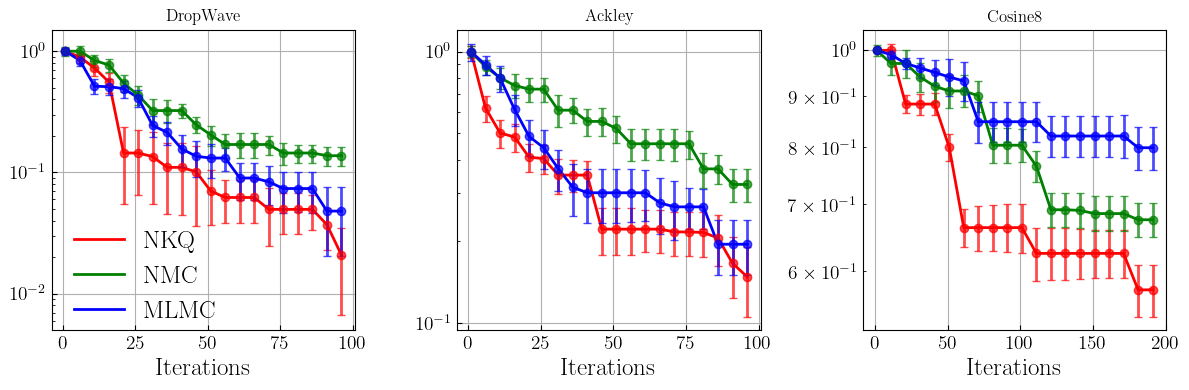

In [63]:
iter_array_100 = np.arange(1, 101, 5)
iter_array_200 = np.arange(1, 201, 10)
dataset_to_plot = ['dropwave', 'ackley', 'cosine8']
dataset_name_dict = {'dropwave': 'DropWave', 'cosine8': 'Cosine8', 'ackley': 'Ackley'}
cmap = plt.get_cmap('Set1')


# Create a figure with 3 subplots, arranged vertically
fig, axs = plt.subplots(1, len(dataset_to_plot), figsize=(4 * len(dataset_to_plot), 4))  # 3 rows, 1 column of subplots

for id, dataset in enumerate(dataset_to_plot):
    if dataset == 'cosine8':
        iter_array = iter_array_200
    else:
        iter_array = iter_array_100
    axs[id].plot(iter_array, I_nkq_mean_dict[dataset], label='NKQ', color='red')
    axs[id].errorbar(iter_array, I_nkq_mean_dict[dataset], yerr=I_nkq_ste_dict[dataset], fmt='o', color='red', alpha=0.7, capsize=3)

    axs[id].plot(iter_array, I_nmc_mean_dict[dataset], label='NMC', color='green')
    axs[id].errorbar(iter_array, I_nmc_mean_dict[dataset], yerr=I_nmc_ste_dict[dataset], fmt='o', color='green', alpha=0.7, capsize=3)

    axs[id].plot(iter_array, I_mlmc_mean_dict[dataset], label='MLMC', color='blue')
    axs[id].errorbar(iter_array, I_mlmc_mean_dict[dataset], yerr=I_mlmc_ste_dict[dataset], fmt='o', color='blue', alpha=0.7, capsize=3)

    axs[id].set_xlabel('Iterations')
    if id == 0:
        axs[id].set_ylim([0.005, 1.5])
    axs[id].set_yscale('log')
    if id == 0:
        axs[id].legend(bbox_to_anchor=(0.001, -0.05), loc='lower left')
    axs[id].set_title(f'{dataset_name_dict[dataset]}')

plt.tight_layout()
os.chdir(f'/home/zongchen/nest_bq/')
plt.savefig('./figures/bo.pdf', bbox_inches='tight')
# Show the plot
plt.show()

